In [20]:
import zarr
import xarray as xr
import dask.array as da
import numpy as np

# Path to your Zarr store
zarr_path = r"pea.zarr"

# Open the Zarr file with xarray
ds = xr.open_zarr(zarr_path)

ds

<xarray.Dataset>
Dimensions:  (c: 9270, z: 1, y: 133, x: 131)
Dimensions without coordinates: c, z, y, x
Data variables:
    0        (c, z, y, x) float32 dask.array<chunksize=(1000, 1, 133, 131), meta=np.ndarray>
Attributes:
    imzml:        {'source': 'C:\\Users\\tvisv\\OneDrive\\Desktop\\Taste of M...
    multiscales:  [{'axes': ['c', 'z', 'y', 'x'], 'datasets': [{'path': '0'}]...

In [23]:
import zarr
zarr_group = zarr.open_group(zarr_path, mode='r')
print(zarr_group.tree())


/
 ├── 0 (9270, 1, 133, 131) float32
 └── labels
     ├── lengths
     │   └── 0 (1, 1, 133, 131) uint32
     └── mzs
         └── 0 (9270, 1, 133, 131) float64


c:\Users\tvisv\anaconda3\envs\zarrconverter\Lib\site-packages\IPython\core\interactiveshell.py:3577: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  exec(code_obj, self.user_global_ns, self.user_ns)


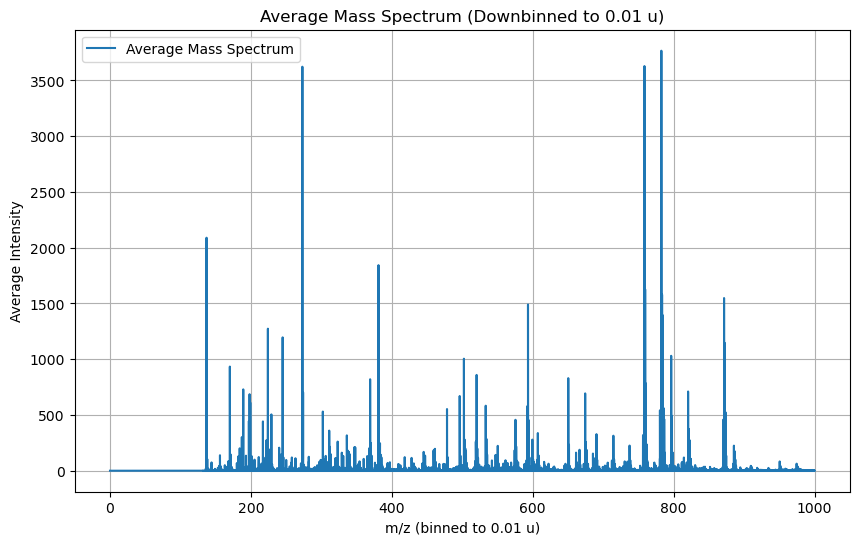

In [ ]:
import dask.array as da
import zarr
import matplotlib.pyplot as plt
import numpy as np

# Open the Zarr file directly with zarr
zarr_group = zarr.open_group(zarr_path, mode='r')

# Load m/z and intensity arrays as Dask arrays
mzs = da.from_zarr(zarr_group['labels/mzs/0'])  # Load m/z array lazily
intensities = da.from_zarr(zarr_group['0'])  # Load intensity array lazily

# Downbinning resolution
bin_resolution = 0.001

# Flatten the arrays along spatial dimensions
flat_mzs = mzs.ravel()
flat_intensities = intensities.ravel()

# Filter out empty or zero-length data using Dask
valid_indices = ~da.isnan(flat_mzs)
flat_mzs = flat_mzs[valid_indices]
flat_intensities = flat_intensities[valid_indices]

# Compute min and max m/z values for binning
min_mz, max_mz = da.compute(flat_mzs.min(), flat_mzs.max())
bins = np.arange(min_mz, max_mz + bin_resolution, bin_resolution)

# Calculate the binned intensities using Dask
binned_intensities = da.histogram(flat_mzs, bins=bins, weights=flat_intensities)[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# Normalize the intensities to calculate the average spectrum
total_pixels = intensities.shape[2] * intensities.shape[3]  # y * x
average_spectrum = binned_intensities / total_pixels

# Compute the result to get the average spectrum
average_spectrum = average_spectrum.compute()

# Plot the average mass spectrum
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, average_spectrum, label="Average Mass Spectrum")
plt.xlabel('m/z (binned to 0.001 u)')
plt.ylabel('Average Intensity')
plt.title('Average Mass Spectrum (Downbinned to 0.001 u)')
plt.legend()
plt.grid(True)
plt.show()


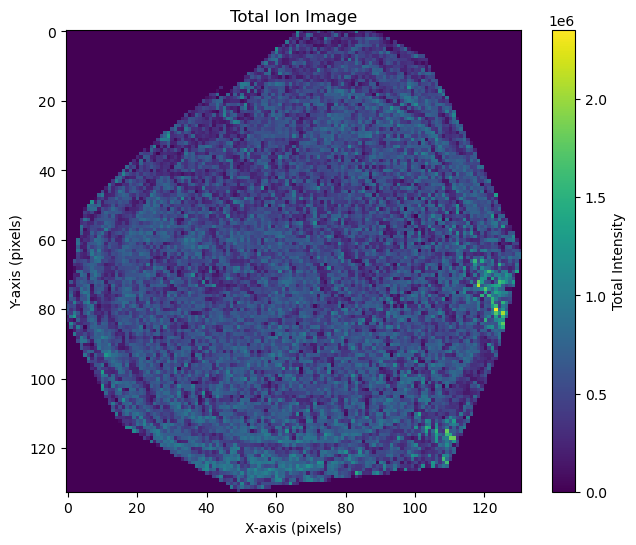

In [28]:
import dask.array as da
import zarr
import matplotlib.pyplot as plt

# Open the Zarr file directly with zarr
zarr_group = zarr.open_group(zarr_path, mode='r')

# Load intensity array as Dask array
intensities = da.from_zarr(zarr_group['0'])  # Intensity array (c, z, y, x)

# Sum intensities along the m/z axis (first axis: `c`)
total_ion_image = intensities.sum(axis=0)  # Resulting shape: (z, y, x)

# Compute the total ion image
total_ion_image = total_ion_image.compute()

# Plot the total ion image (assuming 2D for a single z-plane)
plt.figure(figsize=(8, 6))
plt.imshow(total_ion_image[0], cmap='viridis')  # Select the first z-plane
plt.colorbar(label='Total Intensity')
plt.title('Total Ion Image')
plt.xlabel('X-axis (pixels)')
plt.ylabel('Y-axis (pixels)')
plt.show()


In [6]:
# Define m/z bins
min_mz = 100.0   # Minimum m/z value (adjust as needed)
max_mz = 1000.0  # Maximum m/z value (adjust as needed)
bin_width = 0.1  # Width of each m/z bin
bins = np.arange(min_mz, max_mz + bin_width, bin_width)

# Number of bins
num_bins = len(bins) - 1

# Function to compute histogram per block
def block_histogram(intensities_block, mzs_block, lengths_block):
    import numpy as np

    c_size, z_size, y_size, x_size = intensities_block.shape
    num_pixels = z_size * y_size * x_size

    # Reshape data
    intensities_flat = intensities_block.reshape(c_size, num_pixels)
    mzs_flat = mzs_block.reshape(c_size, num_pixels)
    lengths_flat = lengths_block.reshape(1, num_pixels).squeeze()

    valid_mzs = []
    valid_intensities = []

    for i in range(num_pixels):
        length = int(lengths_flat[i])
        if length == 0:
            continue
        mzs_pixel = mzs_flat[:length, i]
        intensities_pixel = intensities_flat[:length, i]
        valid_mzs.append(mzs_pixel)
        valid_intensities.append(intensities_pixel)

    if not valid_mzs:
        return np.zeros((num_bins,), dtype=np.float64)

    valid_mzs = np.concatenate(valid_mzs)
    valid_intensities = np.concatenate(valid_intensities)

    # Compute histogram
    hist, _ = np.histogram(valid_mzs, bins=bins, weights=valid_intensities)
    return hist

# Apply the function using Dask's map_blocks
histograms = da.map_blocks(
    block_histogram,
    intensities,
    mzs,
    lengths,
    dtype=np.float64,
    new_axis=[0],  # The output is 1D
)

# Sum histograms across all blocks
total_histogram = histograms.sum(axis=0).compute()

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the binned average mass spectrum
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, total_histogram)
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title('Binned Average Mass Spectrum')
plt.show()


IndexError: tuple index out of range